# Labels

We want to use the Radio Galaxy Zoo click data as training data. To do this, we first need to convert the raw click data to a useful label &mdash; most likely the $(x, y)$ coordinate of the host galaxy for a given set of radio emissions.

Let's start by analysing what we're looking at in the raw data.

In [3]:
from pprint import pprint
import sys
import warnings

import matplotlib.pyplot
import numpy

%matplotlib inline

sys.path.insert(1, '..')
import crowdastro.data
import crowdastro.show

warnings.simplefilter('ignore', UserWarning)  # astropy always raises warnings on Windows.

## Reading raw classification data

We'll grab a random subject (complete, from the ATLAS survey) and look at its classifications.

In [4]:
subject = crowdastro.data.db.radio_subjects.find_one({'metadata.survey': 'atlas', 'state': 'complete',
                                                      'zooniverse_id': 'ARG0003r18'})

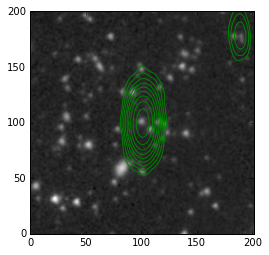

In [5]:
crowdastro.show.subject(subject)
matplotlib.pyplot.show()

This is a kinda nice subject to look at because there are multiple radio sources. This is often true for Radio Galaxy Zoo subjects. Let's look at a classification.

In [10]:
classification = crowdastro.data.db.radio_classifications.find_one({'subject_ids': subject['_id']})
pprint(classification)

{'_id': ObjectId('54b85550bb7b563218000002'),
 'annotations': [{'ir': {'0': {'x': '215.44094848632812',
                               'y': '211.6597137451172'}},
                  'radio': {'0': {'scale_height': '2.1144278606965172',
                                  'scale_width': '2.1144278606965172',
                                  'xmax': '122.85618152302268',
                                  'xmin': '80.9806809782321',
                                  'ymax': '148.59797461973457',
                                  'ymin': '50.36754313888382'}}},
                 {'ir': {'0': {'x': '402.4409484863281',
                               'y': '48.65971374511719'}},
                  'radio': {'0': {'scale_height': '2.1144278606965172',
                                  'scale_width': '2.1144278606965172',
                                  'xmax': '198.21655859377296',
                                  'xmin': '178.38630228611456',
                                  'ymax': '44.87593

We only really care about the annotations, so I've pulled those out. Some of them aren't useful &mdash; the langauge, user agent, and start/end times here, though there may potentially be more in other classifications. It looks like the ones that *are* useful contain both `'ir'` and `'radio'` keys. I'll use "annotations" to refer to these exclusively from now on.

Each annotation contains an IR component and a radio component. The IR component is obviously where people clicked, though the format is a little unusual &mdash; it seems to have the option for multiple clicks, though I can't come up with a situation in which this would arise. I think we can safely ignore all but the first IR coordinate. The radio component describes which contours are included in this annotation. Volunteers may click on multiple contours that they think have been emitted from the same radio source, and these are grouped here. The combination of radio contours here is important as it affects what the volunteers believe they are classifying (see Banfield et al. 2015 for more details).

We need to pull out something describing which combination of radio contours were selected, as well as the actual IR coordinate associated with each one.

In [7]:
def make_radio_combination_signature(radio_annotation):
    """Generates a unique signature for a radio annotation.
    
    radio_annotation: 'radio' dictionary from a classification.
    -> Something immutable
    """
    # My choice of immutable object will be a tuple of the xmax values,
    # sorted to ensure determinism, and rounded to nix floating point errors.
    # Note that the x scale is not the same as the IR scale, but the scale factor is
    # included in the annotation, so I have multiplied this out here for consistency.
    # Sometimes, there's no scale, so I've included a default scale.
    xmaxes = [round(float(c['xmax']) * float(c.get('scale_width', '2.1144278606965172')), 14)
              for c in radio_annotation.values()]
    return tuple(sorted(xmaxes))

def read_classification(classification):
    """Converts a raw RGZ classification into radio combinations and IR locations.
    
    classification: RGZ classification dictionary.
    -> dict mapping radio combination signatures to IR locations.
    """
    result = {}

    for annotation in classification['annotations']:
        if 'radio' not in annotation:
            # This is a metadata annotation and we can ignore it.
            continue
        
        radio_signature = make_radio_combination_signature(annotation['radio'])
        
        if annotation['ir'] == 'No Sources':
            ir_location = None
        else:
            ir_location = (float(annotation['ir']['0']['x']), float(annotation['ir']['0']['y']))

        result[radio_signature] = ir_location

    return result

In [8]:
read_classification(classification)

{(259.77053307106786,): (215.44094848632812, 211.6597137451172),
 (419.1146139420572,): (402.4409484863281, 48.65971374511719)}

Now let's try running that over a few classifications, to see if anything breaks.

In [9]:
for classification in crowdastro.data.db.radio_classifications.find().limit(100):
    print(read_classification(classification))

{}
{}
{}
{}
{(183.4725288692084,): (112.5, 381.0), (335.4714873147084, 374.2027114828553): (213.5, 212.0)}
{}
{}
{(183.4725288692084,): (116.0, 379.0), (335.4714873147084, 374.2027114828553): (216.0, 211.0)}
{(183.4725288692084,): (103.0, 378.0), (335.4714873147084, 374.2027114828553): None}
{(183.4725288692084,): (114.0, 374.0), (335.4714873147084, 374.2027114828553): None}
{(183.4725288692084,): (111.5, 383.0), (335.4714873147084, 374.2027114828553): (213.5, 209.0)}
{}
{}
{}
{}
{(183.4725288692084,): (112.0, 380.0), (335.4714873147084, 374.2027114828553): (214.0, 211.0)}
{(183.4725288692084,): (103.0, 378.0), (335.4714873147084, 374.2027114828553): None}
{(183.4725288692084,): (114.0, 383.0), (335.4714873147084, 374.2027114828553): (214.0, 211.0)}
{(335.4714873147084, 374.2027114828553): (213.0, 211.0)}
{(183.4725288692084,): (112.0, 381.0)}
{(183.4725288692084,): (112.0, 378.0), (335.4714873147084, 374.2027114828553): (212.0, 211.0)}
{(183.4725288692084,): (111.0, 380.0), (335.47148

This seems to work pretty well! The next step is to freeze the whole classification database in this simplified form. I'll do this in a script in `crowdastro.__main__`.

This section is summarised in `crowdastro.labels.parse_classification`.

Now we can move on to using these to find the consensus for each subject.


## Finding consensus radio/location mapping

Given these simplified 